### Tensorflow slim API : VGG16 CNN architecture
- VGG : Visual Geometry Group, an academic group focused on computer vision

#### Following are the points we are able to cover with the notebook:
- Download VGG16 model build on Imagenet dataset from TensorFlow-Slim image classification model library
- Make inference on images using the model
- Extract the basic meta data of Tensorflow model

Tensorflow slim api: https://github.com/tensorflow/models/blob/master/research/slim/slim_walkthrough.ipynb

Packages referece: https://github.com/tensorflow/models/tree/master/research/slim

VGG 16 Model location: http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import os
import tensorflow as tf

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

/home/ubuntu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sys.path.append(r"/home/ubuntu/model_compression/enviornment/models/research/slim"); from datasets import imagenet
#from tensorflow.contrib.slim.nets import vgg
sys.path.append(r"/home/ubuntu/model_compression/enviornment/models/research/slim/nets"); import vgg
#from preprocessing import vgg_preprocessing
sys.path.append(r"/home/ubuntu/model_compression/enviornment/models/research/slim/preprocessing"); import vgg_preprocessing 

from tensorflow.contrib import slim
os.chdir('/home/ubuntu/model_compression/models/VGG_16/TF')

Instructions for updating:
Use the retry module or similar alternatives.


Tensor("ExpandDims_1:0", shape=(1, 224, 224, 3), dtype=float32)
INFO:tensorflow:Restoring parameters from /home/ubuntu/model_compression/models/VGG_16/vgg_16.ckpt


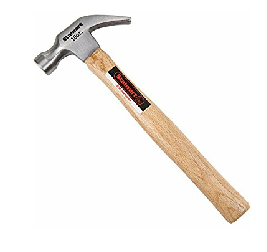

Probability 72.96% => [hammer]
Probability 26.64% => [hatchet]
Probability 0.27% => [shovel]
Probability 0.04% => [paintbrush]
Probability 0.02% => [spatula]


In [3]:
config = tf.ConfigProto(device_count = {'GPU': 0})

image_size = vgg.vgg_16.default_image_size

with tf.Graph().as_default():
    url = 'https://images-na.ssl-images-amazon.com/images/I/41Mg9AGRbRL._SL500_AC_SS350_.jpg'
    image_string = urllib.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = vgg_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    print(processed_images)
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        # 1000 classes instead of 1001.
        logits, _ = vgg.vgg_16(processed_images, num_classes=1000, is_training=False)
    probabilities = tf.nn.softmax(logits)
    #init_fn = slim.assign_from_checkpoint_fn('/home/ubuntu/model_compression/models/VGG_16/TF/vgg_16.ckpt',slim.get_model_variables('vgg_16'))
    init_fn = slim.assign_from_checkpoint_fn('/home/ubuntu/model_compression/models/VGG_16/vgg_16.ckpt',slim.get_model_variables('vgg_16'),ignore_missing_vars=True)
    saver=tf.train.Saver()
    vgg_16_gf=tf.get_default_graph()
    tf.train.write_graph(vgg_16_gf,logdir='/home/ubuntu/model_compression/models/VGG_16/TF',name='vgg16.pb',as_text=False)
    tf.train.write_graph(vgg_16_gf,logdir='/home/ubuntu/model_compression/models/VGG_16/TF',name='vgg16.pbtxt',as_text=True)
    with tf.Session(config=config) as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        saver.save(sess,'/home/ubuntu/model_compression/models/VGG_16/TF/VGG16_model.ckpt', meta_graph_suffix='meta', write_meta_graph=True,)
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()
    
    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        # Shift the index of a class name by one. 
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index+1]))

In [4]:
!ls -l /home/ubuntu/model_compression/models/VGG_16/TF

total 540996
-rw-rw-r-- 1 ubuntu ubuntu       185 Jun  1 10:29 checkpoint
-rw-rw-r-- 1 ubuntu ubuntu 553430176 Jun  1 10:29 VGG16_model.ckpt.data-00000-of-00001
-rw-rw-r-- 1 ubuntu ubuntu      1453 Jun  1 10:29 VGG16_model.ckpt.index
-rw-rw-r-- 1 ubuntu ubuntu    145973 Jun  1 10:29 VGG16_model.ckpt.meta
-rw-rw-r-- 1 ubuntu ubuntu    107019 Jun  1 10:29 vgg16.pb
-rw-rw-r-- 1 ubuntu ubuntu    277786 Jun  1 10:29 vgg16.pbtxt
